In [70]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
# Set path to google drive
path ="/content/drive/MyDrive/Colab Notebooks/Group_Project_2/BTC_USD_data.csv"



In [73]:
# Read CSV file
data = pd.read_csv(path)

In [74]:
# To see data
data.head()

,Date,BTC
0,1/1/16,433.82
1,1/2/16,433.55
2,1/3/16,431.04
3,1/4/16,434.17
4,1/5/16,432.43


In [75]:
# Prep. data frame
data.rename( columns={'Unnamed: 0':'Date'}, inplace=True )
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.head()

,BTC
Date,
2016-01-01,433.82
2016-01-02,433.55
2016-01-03,431.04
2016-01-04,434.17
2016-01-05,432.43


In [76]:
# Slicing the date range
bit_df = data.loc['2020-03-02':'2021-05-03']
bit_df.head()

,BTC
Date,
2020-03-02,8908.26
2020-03-03,8755.45
2020-03-04,8753.28
2020-03-05,9066.65
2020-03-06,9153.79


In [77]:
# rename the column name
df_1=bit_df.rename(columns={"BTC": "Close"})
df_1.head()

,Close
Date,
2020-03-02,8908.26
2020-03-03,8755.45
2020-03-04,8753.28
2020-03-05,9066.65
2020-03-06,9153.79


In [78]:
# Reset index
df = df_1.reset_index()
df.head()

,Date,Close
0,2020-03-02,8908.26
1,2020-03-03,8755.45
2,2020-03-04,8753.28
3,2020-03-05,9066.65
4,2020-03-06,9153.79


In [79]:
# Add exponential and rolling moving averages
df['EMA_5'] = df['Close'].ewm(5).mean().shift()
df['EMA_10'] = df['Close'].ewm(10).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()


In [80]:
# Set definition to calcluate RSI
def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)


In [81]:
# Add MACD (Moving Average Convergence Divergence)
EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())
df

,Date,Close,EMA_5,EMA_10,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,2020-03-02,8908.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-03-03,8755.45,8908.260000,8908.260000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
2,2020-03-04,8753.28,8824.909091,8828.216667,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
3,2020-03-05,9066.65,8796.572308,8800.822900,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
4,2020-03-06,9153.79,8883.512370,8877.059890,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
423,2021-04-29,53593.97,54319.212398,55480.300888,52662.828,53217.872,55841.143333,57353.122333,29.202507,-1219.348868,-892.691514
424,2021-04-30,57775.27,54198.338665,55308.816261,53357.834,53007.814,55117.400667,57180.901667,42.840374,-854.890397,-885.131290
425,2021-05-01,57851.91,54794.493888,55533.039329,55087.202,53135.022,54753.139333,57147.324667,45.502416,-553.489939,-818.803020
426,2021-05-02,56622.66,55304.063240,55743.845753,55842.902,53539.589,54514.184000,57118.104000,50.787539,-409.102230,-736.862862


In [82]:
# Split stock data frame into three subsets: training ( 95% ), validation ( 2.5% ) and test ( 2.5% ) sets

test_size  = 0.025
valid_size = 0.025

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

train_df.tail()

,Date,Close,EMA_5,EMA_10,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
402,2021-04-08,58096.60,57434.789224,56732.639941,57670.546,58122.813,56770.231333,56956.224000,69.637940,1105.296827,1312.504520
403,2021-04-09,58109.56,57545.091020,56856.636310,57876.982,58172.463,57157.503333,57061.810000,61.218851,1072.654187,1264.534453
404,2021-04-10,59766.93,57639.169183,56970.538463,57856.458,58107.360,57609.733333,57137.052333,63.641631,1167.067341,1245.041031
405,2021-04-11,59979.26,57993.795986,57224.755876,57984.844,58205.795,57922.104000,57203.547000,64.383885,1244.675854,1244.967995
406,2021-04-12,59831.66,58324.706655,57475.165342,58377.036,58330.868,58198.093333,57293.821000,58.651094,1279.521545,1251.878705


In [83]:
# Drop unnecessary columns

train_df = train_df.drop(columns=["Date"])
valid_df = valid_df.drop(columns=["Date"])
test_df  = test_df.drop(columns=["Date"])

train_df.head()

,Close,EMA_5,EMA_10,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,8908.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8755.45,8908.260000,8908.260000,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,8753.28,8824.909091,8828.216667,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,9066.65,8796.572308,8800.822900,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,9153.79,8883.512370,8877.059890,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [84]:
# Set X_train, y_train, X_valid, y_valid, X_test, and y_test
y_train = train_df['Close'].copy()
X_train = train_df.drop(['Close'], 1)

y_valid = valid_df['Close'].copy()
X_valid = valid_df.drop(['Close'], 1)

y_test  = test_df['Close'].copy()
X_test  = test_df.drop(['Close'], 1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407 entries, 0 to 406
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   EMA_5        406 non-null    float64
 1   EMA_10       406 non-null    float64
 2   SMA_5        402 non-null    float64
 3   SMA_10       397 non-null    float64
 4   SMA_15       392 non-null    float64
 5   SMA_30       377 non-null    float64
 6   RSI          406 non-null    float64
 7   MACD         382 non-null    float64
 8   MACD_signal  374 non-null    float64
dtypes: float64(9)
memory usage: 28.7 KB


In [85]:
# set the parameters
parameters = {
# Number of boosted trees to fit
     'n_estimators': [1],  
# boosting learning rate
     'learning_rate': [0.001], 
 # Maximum tree depth for base learnes    
     'max_depth': [5],        
    'random_state': [1]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]

model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False, parameters=parameters)
# objective='reg:squarederror' outputs regression with squared loss

In [86]:
# Fit the model
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1,
             eval_set=[(            EMA_5        EMA_10      SMA_5  ...        RSI         MACD  MACD_signal
0             NaN           NaN        NaN  ...        NaN          NaN          NaN
1     8908.260000   8908.260000        NaN  ...   0.000000          NaN          NaN
2     8824.909091   8828.216667        NaN  ...   0.000000          NaN          NaN
3     8796.572308   8800.822900        NaN  ...   0.000000          NaN          NaN
4     8883.512370   8877.059890        NaN  ...   0.000000          NaN          NaN
..            ......
             gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
             n_estimators=100, n_jobs=1, nthread=None,
             objective='reg:squarederror',
             parameters={'learning_rate': [0.001], 'max_depth': [5],
              

In [87]:
# Run predict
y_pred = model.predict(X_test)

In [88]:
# Define model evaluation method
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
cv = RepeatedKFold(n_splits=7, n_repeats=3, random_state=1)
# evaluate model to calculate mean absolute error
scores = cross_val_score(model, X_test, y_pred, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )
# Calculate R2 (mean_square_error) to evaluate predictions
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

Mean MAE: 950.557 (915.913)
mean_squared_error = 4378945.038900607


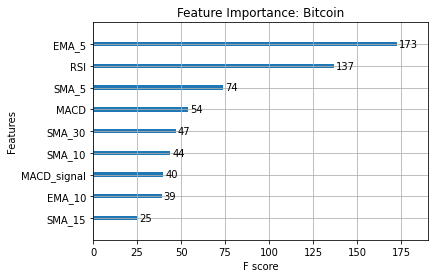

In [98]:
# Plot feature importance
plot_importance(model, title ='Feature Importance: Bitcoin');

In [90]:
# Prep to create a dataframe for the predicted value and actual closing price
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred
predicted_prices.Date
date_pred=pd.DataFrame(predicted_prices.Date)
date_pred=date_pred.reset_index(drop=True)
date_pred

,Date
0,2021-04-24
1,2021-04-25
2,2021-04-26
3,2021-04-27
4,2021-04-28
5,2021-04-29
6,2021-04-30
7,2021-05-01
8,2021-05-02
9,2021-05-03


In [91]:
# Make the predicted value to DataFrame
amazon_pred = pd.DataFrame(y_pred)
# Make X_test value to DataFrame
actual=pd.DataFrame(y_test) 
actual_f=actual.reset_index(drop=True)
actual_f
# Combine date, closing price and predict value
actual_pred = pd.concat([date_pred, actual_f, amazon_pred], axis=1)

# Set the column name for the Predicted value
actual_pred.rename( columns={0 :'Pred'}, inplace=True )
actual_pred

,Date,Close,Pred
0,2021-04-24,50118.94,53174.234375
1,2021-04-25,49128.43,52418.929688
2,2021-04-26,54073.41,55398.468750
3,2021-04-27,55091.39,52448.285156
4,2021-04-28,54901.97,52858.730469
5,2021-04-29,53593.97,52858.730469
6,2021-04-30,57775.27,55814.363281
7,2021-05-01,57851.91,55956.683594
8,2021-05-02,56622.66,58046.890625
9,2021-05-03,57222.37,58061.761719


In [92]:
# Calculate the difference and squar of diff.
actual_pred['Diff'] = actual_pred['Close'] - actual_pred['Pred']
actual_pred['Square'] = actual_pred['Diff']**2
actual_pred

,Date,Close,Pred,Diff,Square
0,2021-04-24,50118.94,53174.234375,-3055.294375,9.334824e+06
1,2021-04-25,49128.43,52418.929688,-3290.499687,1.082739e+07
2,2021-04-26,54073.41,55398.468750,-1325.058750,1.755781e+06
3,2021-04-27,55091.39,52448.285156,2643.104844,6.986003e+06
4,2021-04-28,54901.97,52858.730469,2043.239531,4.174828e+06
5,2021-04-29,53593.97,52858.730469,735.239531,5.405772e+05
6,2021-04-30,57775.27,55814.363281,1960.906719,3.845155e+06
7,2021-05-01,57851.91,55956.683594,1895.226406,3.591883e+06
8,2021-05-02,56622.66,58046.890625,-1424.230625,2.028433e+06
9,2021-05-03,57222.37,58061.761719,-839.391719,7.045785e+05


In [93]:
# calculate the total of diffeences
column_sum = actual_pred['Diff'].sum()
print(f"Total differences {column_sum}")
# calculate the mean squared error
MSE = actual_pred['Square'].mean()
print(f"Mean Squared Error {MSE}")
# Compute the root-mean-square
rms = np.sqrt(MSE)
print(f"Root Mean Square {rms}")
# calculate the mean of the closing prices
ClosingPrice = actual_pred['Close'].mean()
print(f"Mean Closing Price {ClosingPrice}")

Total differences -656.7581249999857
Mean Squared Error 4378945.038900607
Root Mean Square 2092.5928985114633
Mean Closing Price 54638.03200000001


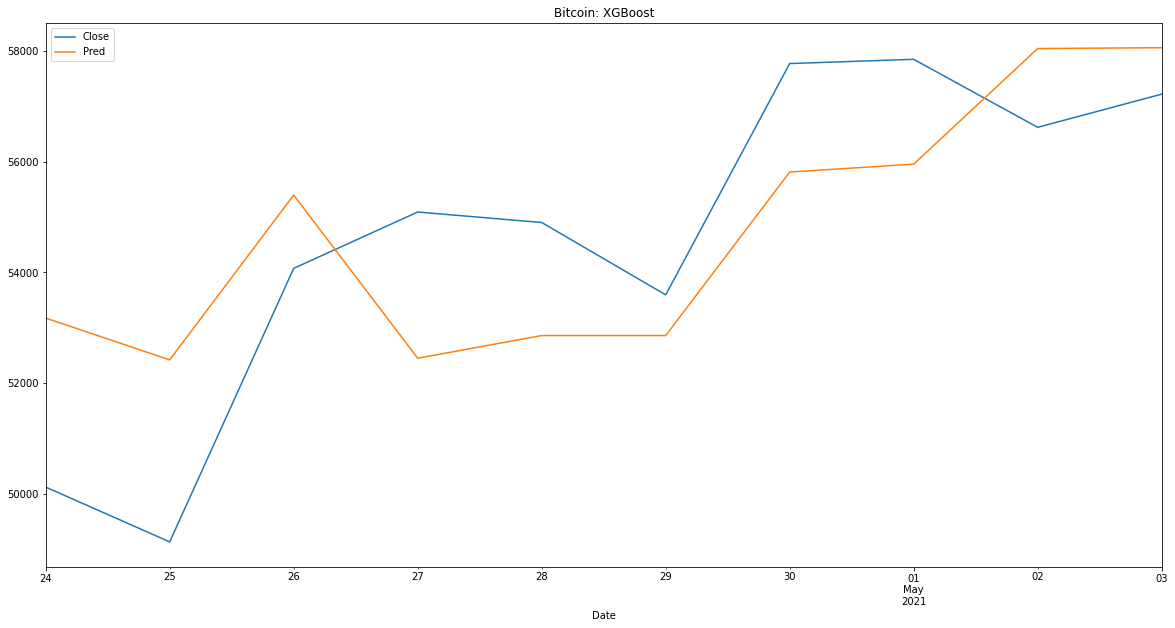

In [94]:
# Plot the closing price and predicted price
actual_pred.plot.line(x="Date", y=["Close", "Pred"],title="Bitcoin: XGBoost", figsize=(20,10));

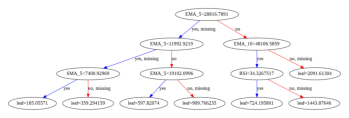

In [95]:
# plot tree
plot_tree(model, num_trees=10);

In [99]:
# Version 2 to try different split point
# Split stock data frame into three subsets: training ( 90% ), validation ( 5% ) and test ( 5% ) sets

test_size  = 0.05
valid_size = 0.05

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

#Drop unnecessary columns

train_df = train_df.drop(columns=["Date"])
valid_df = valid_df.drop(columns=["Date"])
test_df  = test_df.drop(columns=["Date"])
y_train = train_df['Close'].copy()
X_train = train_df.drop(['Close'], 1)

y_valid = valid_df['Close'].copy()
X_valid = valid_df.drop(['Close'], 1)

y_test  = test_df['Close'].copy()
X_test  = test_df.drop(['Close'], 1)

parameters = {
# Number of boosted trees to fit
     'n_estimators': [1],  
# boosting learning rate
     'learning_rate': [0.001], 
 # Maximum tree depth for base learnes    
     'max_depth': [5],        
    'random_state': [1]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]

model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False, parameters=parameters)
# objective:"reg:linear"
# objective='reg:squarederror'

# fit the model
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

# define model evaluation method
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
cv = RepeatedKFold(n_splits=7, n_repeats=3, random_state=1)
# evaluate model to calculate mean absolute error
scores = cross_val_score(model, X_test, y_pred, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive

scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

# Calculate R2 (mean_square_error) to evaluate predictions
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

Mean MAE: 304.181 (217.124)
mean_squared_error = 17969054.06557357


In [ ]:
# Prep to create a dataframe for the predicted value and actual closing price
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred
predicted_prices.Date
date_pred=pd.DataFrame(predicted_prices.Date)
date_pred=date_pred.reset_index(drop=True)

# Make the predicted value to DataFrame
amazon_pred = pd.DataFrame(y_pred)
# Make X_test value to DataFrame
actual=pd.DataFrame(y_test) 
actual_f=actual.reset_index(drop=True)
actual_f
# combine date, closing price and predict value
actual_pred = pd.concat([date_pred, actual_f, amazon_pred], axis=1)

# Set the column name for the Predicted value
actual_pred.rename( columns={0 :'Pred'}, inplace=True )

# calculate the difference and squar of diff.
actual_pred['Diff'] = actual_pred['Close'] - actual_pred['Pred']
actual_pred['Square'] = actual_pred['Diff']**2
actual_pred

,Date,Close,Pred,Diff,Square
0,2021-04-13,63564.48,56951.578125,6612.901875,4.373047e+07
1,2021-04-14,64450.11,57672.449219,6777.660781,4.593669e+07
2,2021-04-15,63239.19,55919.660156,7319.529844,5.357552e+07
3,2021-04-16,61436.24,53649.906250,7786.333750,6.062699e+07
4,2021-04-17,60032.29,53649.906250,6382.383750,4.073482e+07
5,2021-04-18,56280.60,52836.972656,3443.627344,1.185857e+07
6,2021-04-19,55694.55,52706.742188,2987.807813,8.926996e+06
7,2021-04-20,56503.19,52924.238281,3578.951719,1.280890e+07
8,2021-04-21,53806.24,53086.984375,719.255625,5.173287e+05
9,2021-04-22,51683.95,52585.171875,-901.221875,8.122009e+05


In [ ]:
# calculate the total of diffeences
column_sum = actual_pred['Diff'].sum()
print(f"Total differences {column_sum}")
# calculate the mean squared error
MSE = actual_pred['Square'].mean()
print(f"Mean Squared Error {MSE}")
# Compute the root-mean-square
rms = np.sqrt(MSE)
print(f"Root Mean Square {rms}")
# calculate the mean of the closing prices
ClosingPrice = actual_pred['Close'].mean()
print(f"Mean Closing Price {ClosingPrice}")


Total differences 61659.50140625002
Mean Squared Error 17969054.065573566
Root Mean Square 4238.992104919937
Mean Closing Price 56392.75285714286


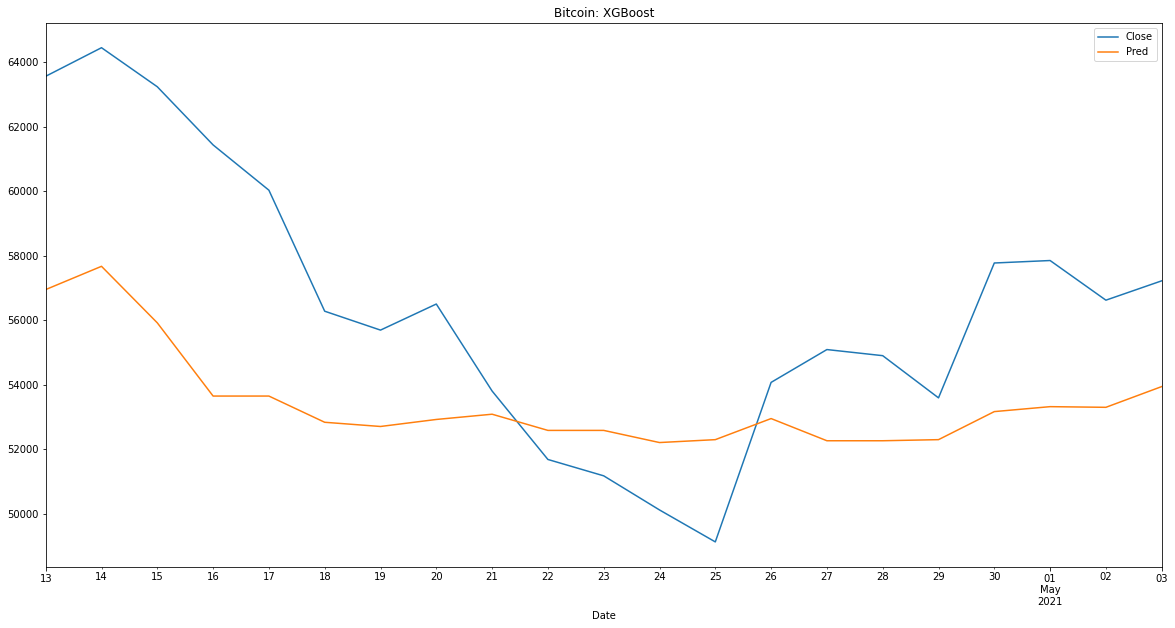

In [ ]:
# Plot the closing price and predicted price
actual_pred.plot.line(x="Date", y=["Close", "Pred"],title="Bitcoin: XGBoost", figsize=(20,10));

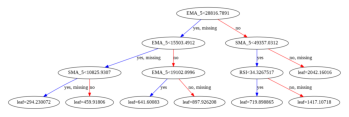

In [ ]:
# plot tree
plot_tree(model, num_trees=10);